In [1]:
#import rpy2.robjects as robjects
#import rpy2.robjects.packages as rpackages
#from rpy2.robjects import pandas2ri
#from rpy2.robjects.conversion import localconverter
from anndata import AnnData
import scanpy as sc
from os import path
import os
#from rpy2.robjects.packages import importr
#base = importr('base')
import numpy as np
from gpzoo.kernels import NSF_RBF, RBF
from gpzoo.likelihoods import NSF2
from tqdm.auto import tqdm
from gpzoo.gp import SVGP, VNNGP
from gpzoo.utilities import rescale_spatial_coords, dims_autocorr, regularized_nmf, add_jitter, scanpy_sizefactors, deviancePoisson, anndata_to_train_val #init_softplus
import random
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
import gpzoo.pri_experiment_utilities as putil
from sklearn.metrics import root_mean_squared_error, mean_poisson_deviance
import torch
from torch import optim, distributions, nn
import time
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import acf

/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
random.seed(256)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
root_path = "/engelhardt/home/pshrestha/vnngp/"
SPATH = path.join(root_path, 'results/merfish')
nsf_path = path.join(SPATH, 'nsf')
nnnsf_path = path.join(SPATH, 'nnnsf')
dpth = path.join(root_path, "data/")
merpath = path.join(dpth, "merfish.h5ad")

In [4]:
adata = sc.read_h5ad(merpath)

In [5]:
adata

AnnData object with n_obs × n_vars = 21458 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'seurat_clusters', 'nCount_LMO', 'nFeature_LMO', 'LMO_maxID', 'LMO_secondID', 'LMO_margin', 'LMO_classification', 'LMO_classification.global', 'hash.ID', 'nCount_SCT', 'nFeature_SCT', 'Celltype', 'Celltype.LowRes', 'Age', 'S.Score', 'G2M.Score', 'Phase', 'SCT_snn_res.0.5', 'SCT_snn_res.0.2', 'SCT_snn_res.0.1', 'SCT_snn_res.0.15', 'SCT_snn_res.0.18', 'SCT_snn_res.0.19', 'SCT_snn_res.0.17', 'SCT_snn_res.0.3', 'SCT_snn_res.0.4', 'Prolif_Lineage_Fraction_of_SVZ'
    var: 'sct.detection_rate', 'sct.gmean', 'sct.variance', 'sct.residual_mean', 'sct.residual_variance', 'sct.variable'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'X_umap_har'
    varm: 'HARMONY', 'PCs'

In [6]:
# Calculate the percentage of mitochondrial genes
adata = adata[(adata.obs['percent.mt'] < 5), :]

In [7]:
# Filter cells with at least 500 genes detected
min_genes_per_cell = 500
adata = adata[adata.obs['nFeature_RNA'] >= min_genes_per_cell, :]

In [8]:
#ad.var["mt"] = ad.var_names.str.startswith("mt-")
#sc.pp.calculate_qc_metrics(ad, qc_vars=["mt"], inplace=True)
#ad = ad[ad.obs.pct_counts_mt < 20]
#sc.pp.filter_genes(ad, min_cells=1)
#sc.pp.filter_cells(ad, min_counts=100)
#ad.layers = {"counts":ad.X.copy()}

In [9]:
adata.X.shape

(17252, 3000)

In [10]:
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: 

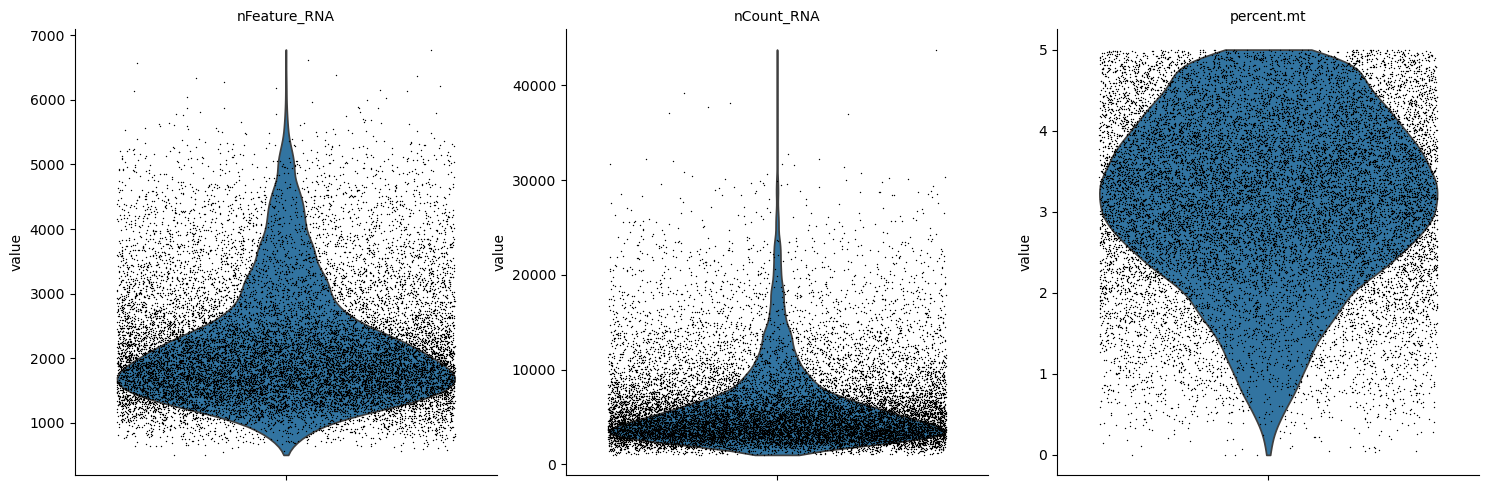

In [11]:
sc.pl.violin(adata, ['nFeature_RNA', 'nCount_RNA', 'percent.mt'], jitter=0.4, multi_panel=True)

In [12]:
labels = adata.obs.Age.unique()
adata.obs['Age_cat'] = adata.obs['Age'].astype('category')
adata = adata[~adata.obs['Age'].isin([20.8, 22.6, 3.33])]

In [13]:
#Y_sums = np.array(np.sum(ad.raw.X > 0, axis=0))[0]
min_value = np.nanmin(adata.X)
print(min_value)
if min_value < 0:
    adata.X += np.abs(min_value)
Y = np.array(adata.X, dtype=int).T
X = adata.obsm['X_harmony']
X = X.astype('float64')
Y = Y.astype('float64')
X = rescale_spatial_coords(X)

-8.701701306928275


In [14]:
adata.uns['counts'] = adata.X.copy()

/tmp/ipykernel_3228260/850897659.py:1: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['counts'] = adata.X.copy()


In [15]:
adata.var['deviance_poisson'] = deviancePoisson(adata.uns["counts"])
o = np.argsort(-adata.var['deviance_poisson'])
idx = list(range(adata.shape[0]))
random.shuffle(idx)
adata = adata[idx,o]

In [16]:
print(X.shape)
print(Y.shape)

(15582, 50)
(3000, 15582)


/tmp/ipykernel_3228260/160309461.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Celltype'] = adata.obs['Celltype'].astype('category')


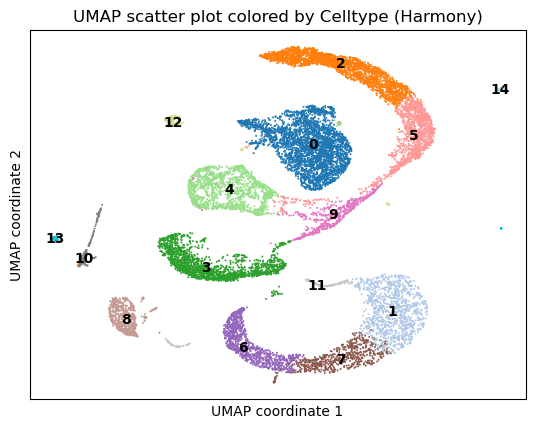

In [17]:
# Ensure the 'Celltype' column is treated as a categorical variable
adata.obs['Celltype'] = adata.obs['Celltype'].astype('category')

# Plot UMAP with discrete colors
sc.pl.embedding(
    adata, 
    basis='umap_har', 
    color='Celltype', 
    title='UMAP scatter plot colored by Celltype (Harmony)', 
    palette='tab20',  # Change this to other color palettes if needed
    legend_loc='on data',  # Optional: Place the legend directly on the plot
    show=False,
)
plt.xlabel("UMAP coordinate 1")
plt.ylabel("UMAP coordinate 2")
plt.show()

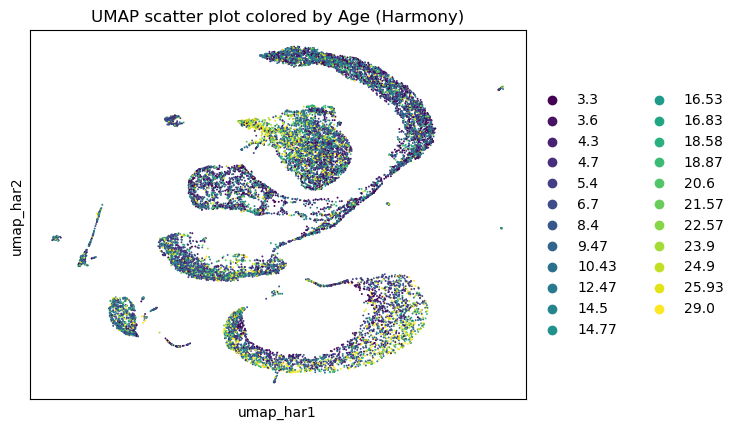

In [18]:
# Ensure 'Age_cat' is treated as a categorical variable (if not already)
adata.obs['Age_cat'] = adata.obs['Age_cat'].astype('category')

# Plot UMAP with discrete colors for each Age category
sc.pl.embedding(
    adata, 
    basis='umap_har', 
    color='Age_cat', 
    title='UMAP scatter plot colored by Age (Harmony)', 
    palette='viridis',  # Or any other discrete color palette you prefer
    legend_loc='right margin'  # Place the legend on the side
)

# Show the plot
plt.show()

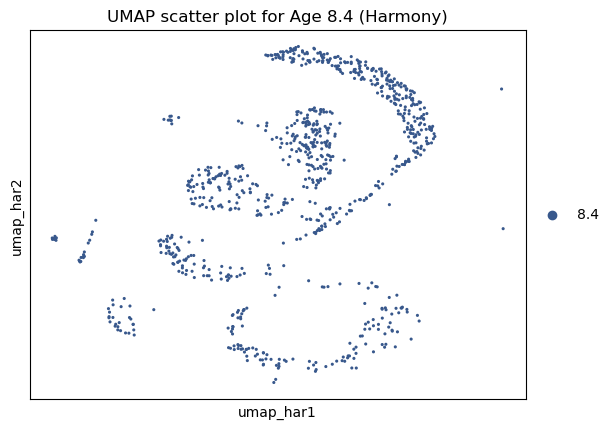

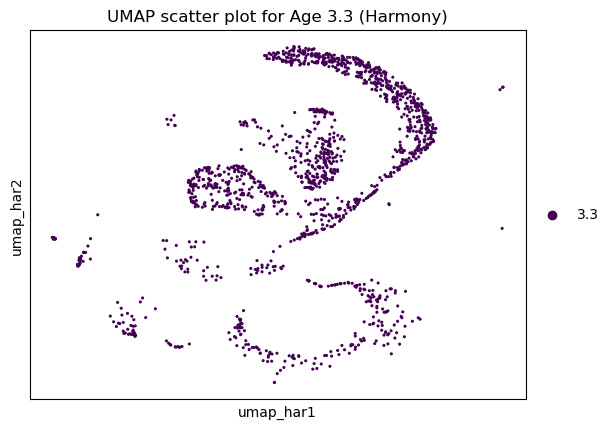

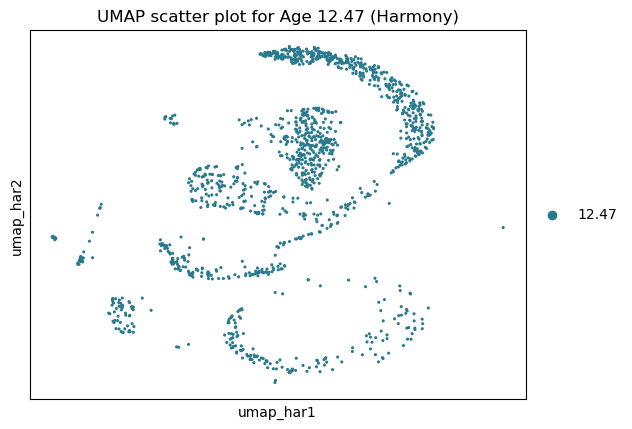

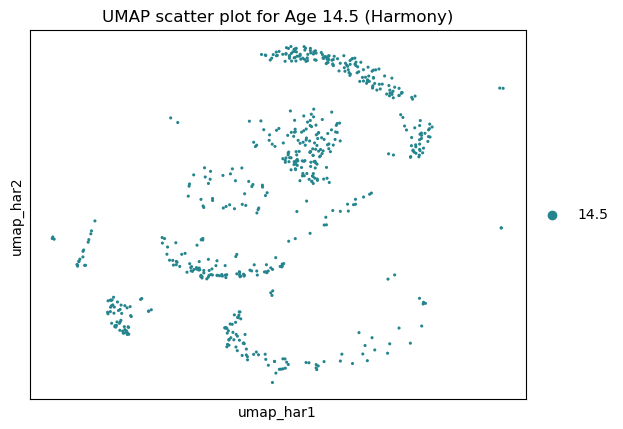

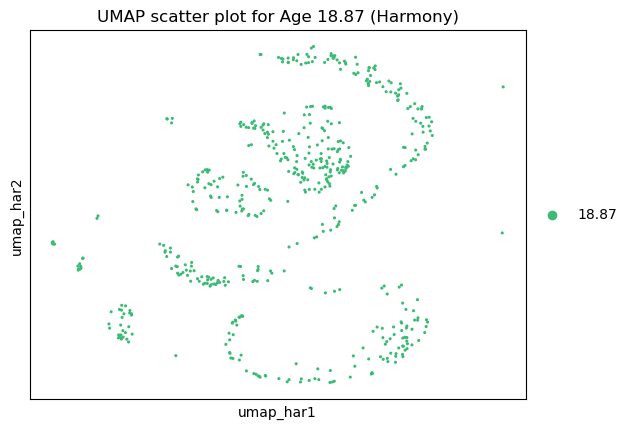

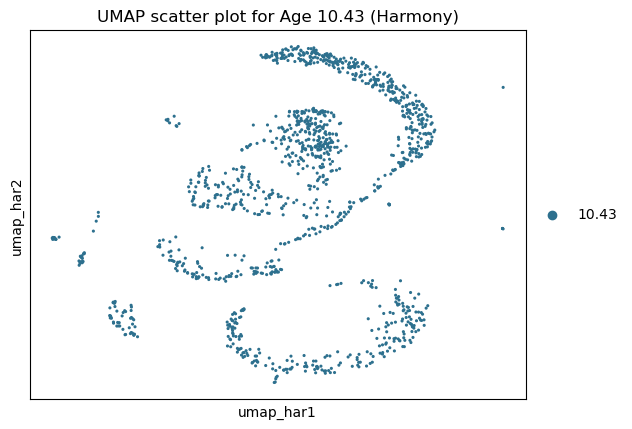

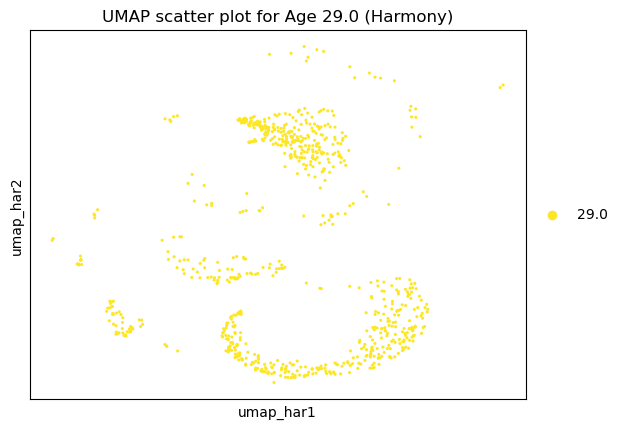

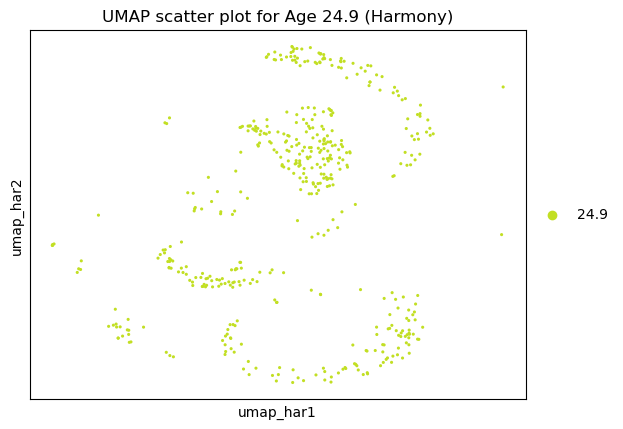

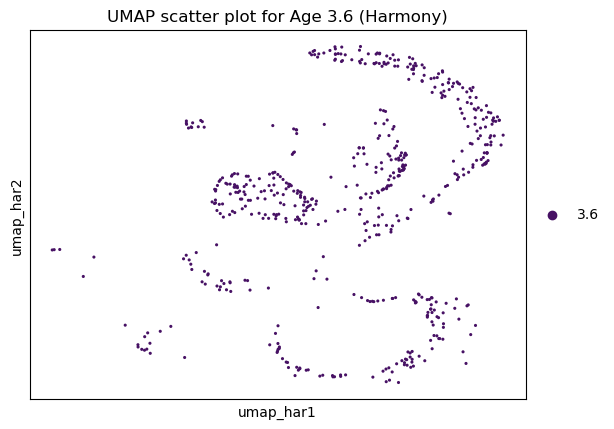

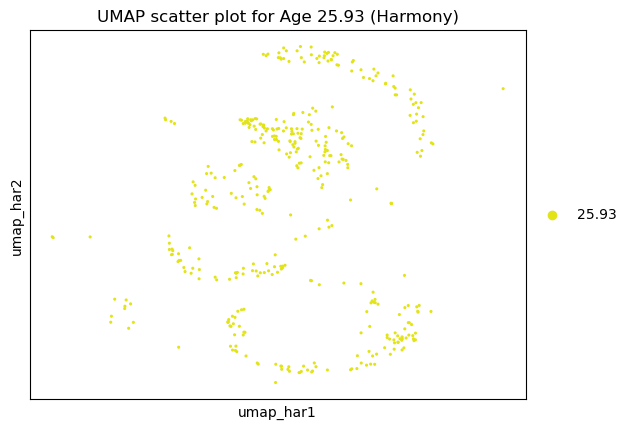

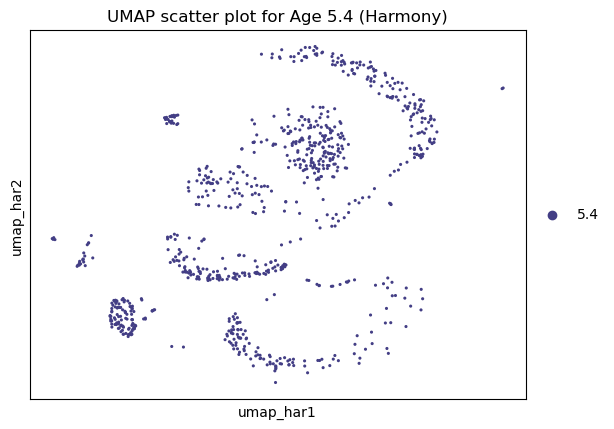

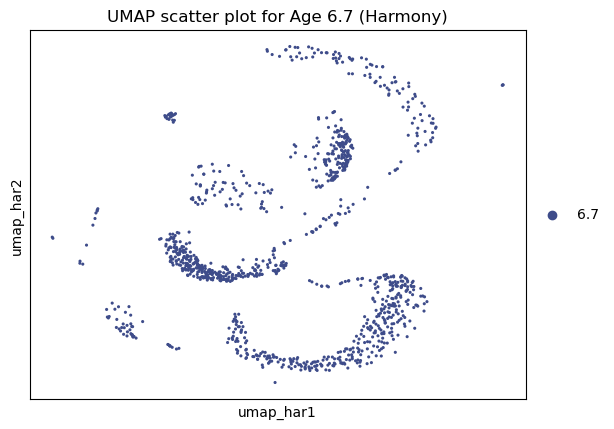

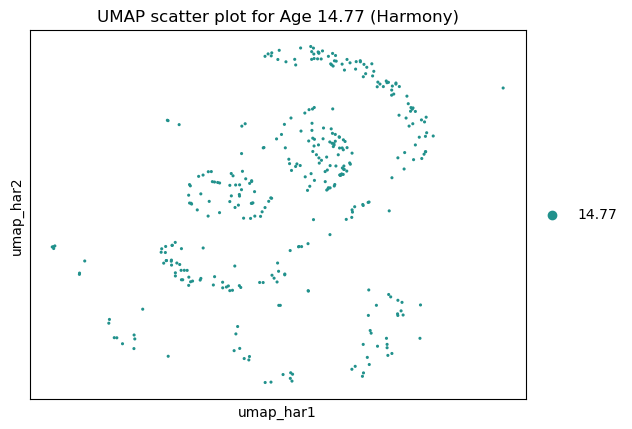

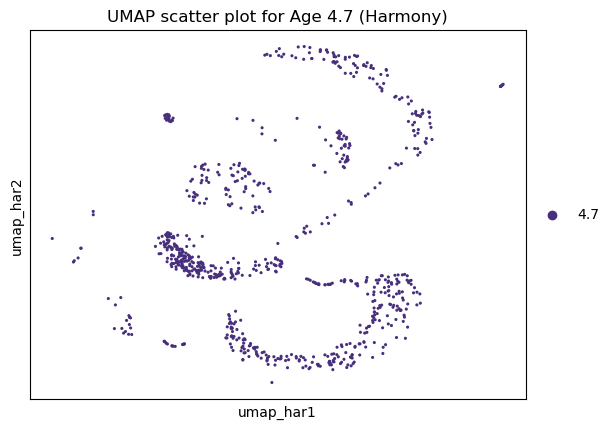

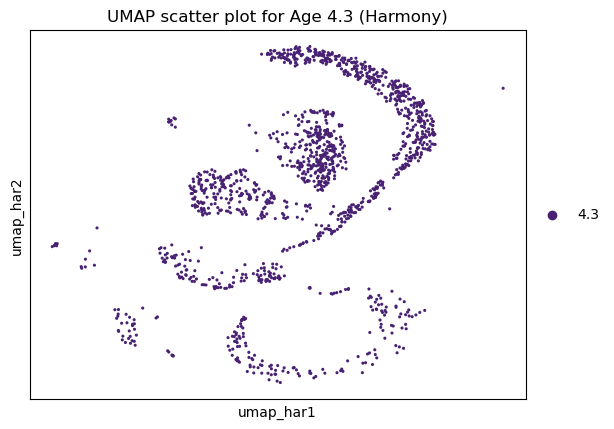

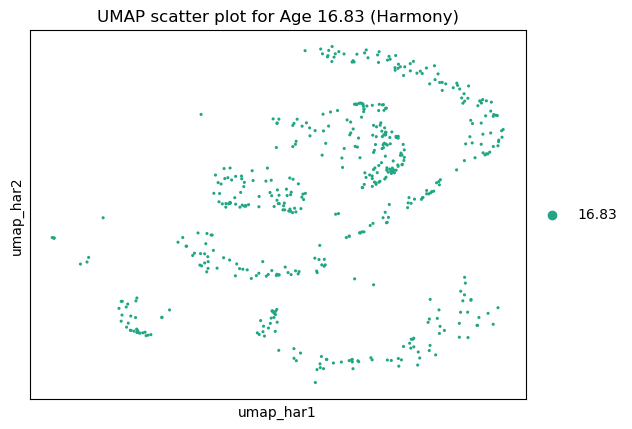

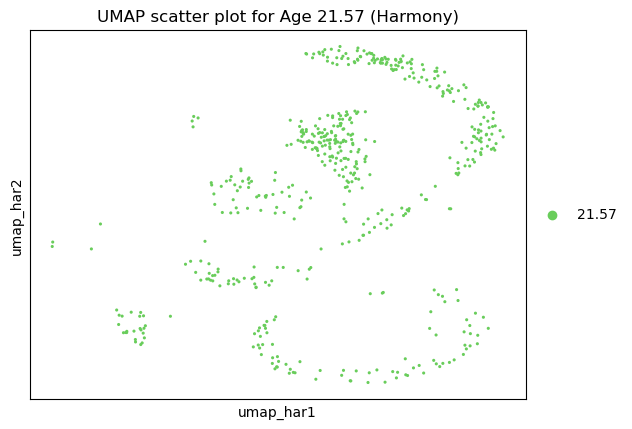

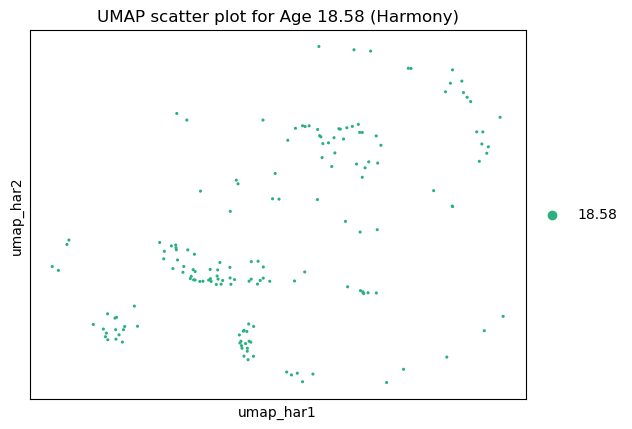

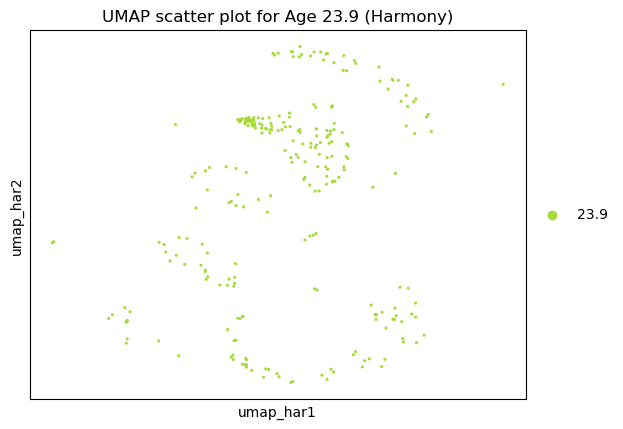

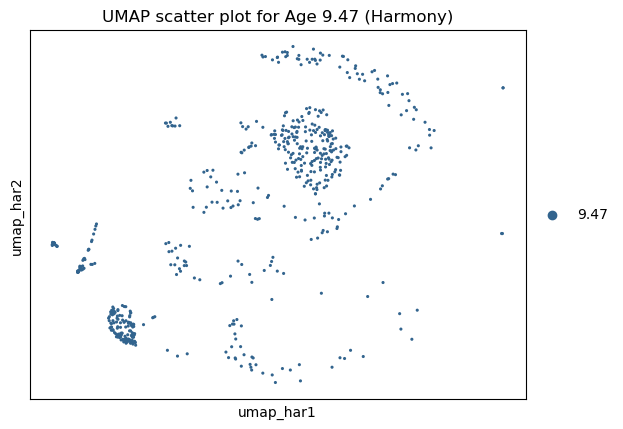

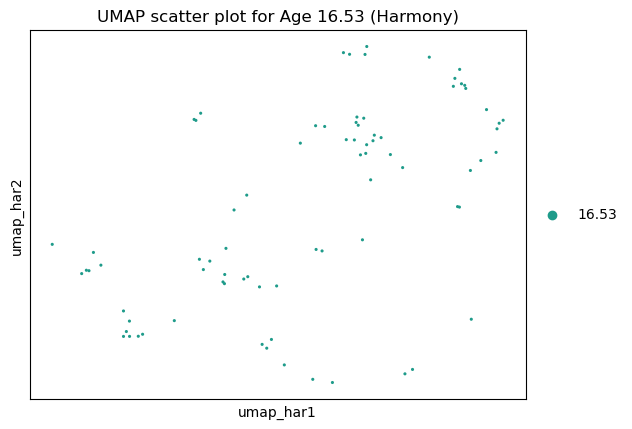

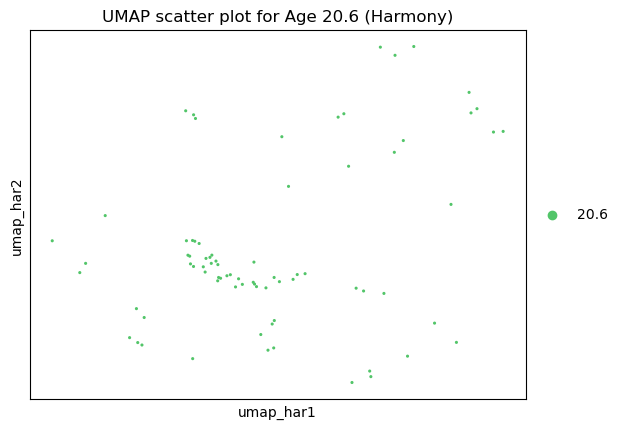

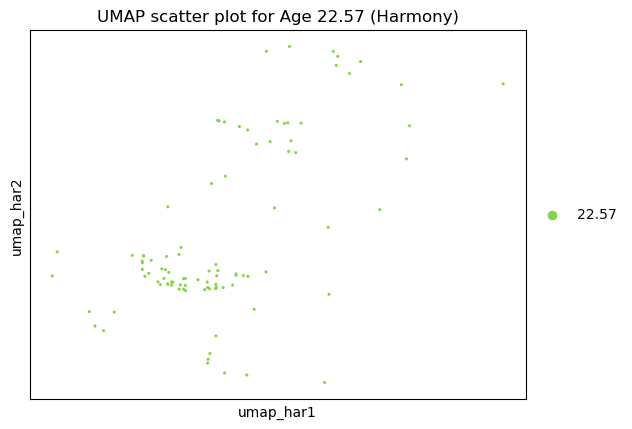

In [19]:
unique_ages = adata.obs['Age_cat'].unique()

for age in unique_ages:
    # Filter the data for the current age category
    ad_age_filtered = adata[adata.obs['Age_cat'] == age]
    
    # Plot UMAP for the current age category
    sc.pl.embedding(ad_age_filtered, 
                    basis='umap_har', 
                    color='Age_cat', 
                    title=f'UMAP scatter plot for Age {age} (Harmony)', 
                    cmap='rocket', size=20)

/tmp/ipykernel_3228260/150890850.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = df.pivot_table(index='Age', columns='Phase', aggfunc='size', fill_value=0)


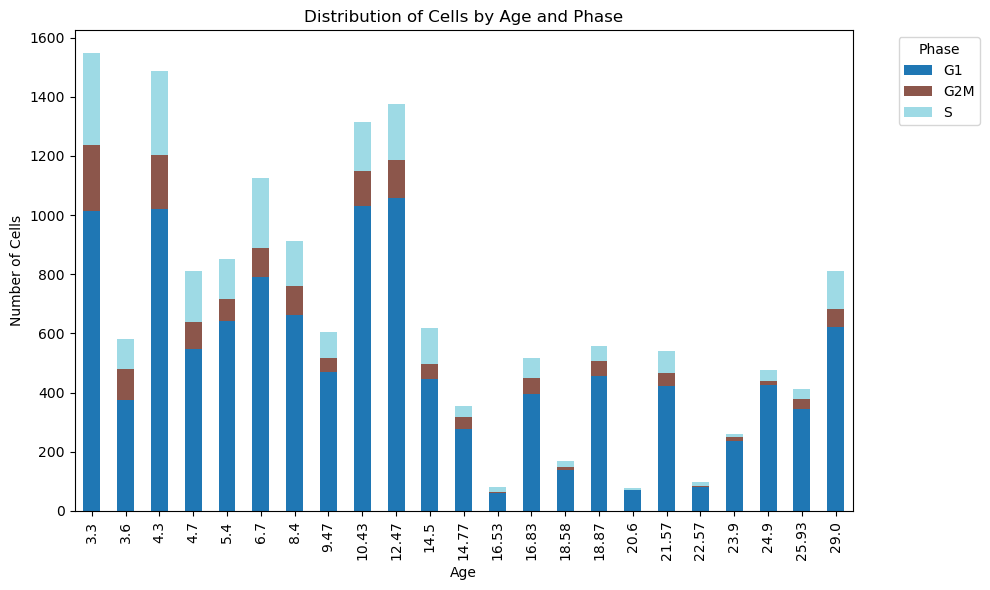

In [20]:
# Extract the relevant columns from the AnnData object
df = adata.obs[['Age', 'Phase']]

# Create a pivot table to get counts of each Celltype per Age
pivot_df = df.pivot_table(index='Age', columns='Phase', aggfunc='size', fill_value=0)

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

plt.xlabel('Age')
plt.ylabel('Number of Cells')
plt.title('Distribution of Cells by Age and Phase')
plt.xticks(rotation=90)
plt.legend(title='Phase', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

/tmp/ipykernel_3228260/1957380345.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = df.pivot_table(index='Age', columns='Celltype', aggfunc='size', fill_value=0)


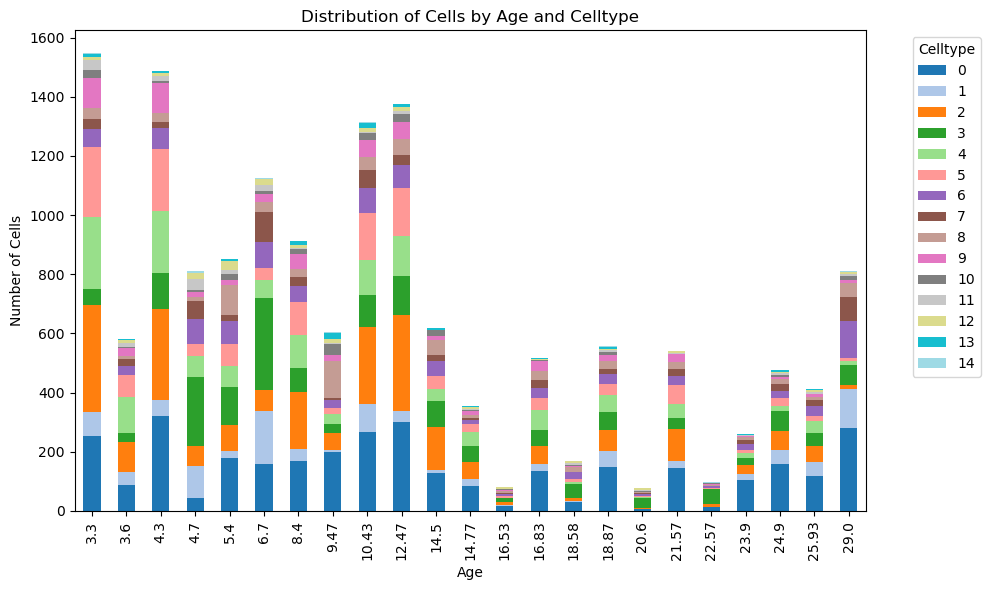

In [21]:
# Extract the relevant columns from the AnnData object
df = adata.obs[['Age', 'Celltype']]

# Create a pivot table to get counts of each Celltype per Age
pivot_df = df.pivot_table(index='Age', columns='Celltype', aggfunc='size', fill_value=0)

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

plt.xlabel('Age')
plt.ylabel('Number of Cells')
plt.title('Distribution of Cells by Age and Celltype')
plt.xticks(rotation=90)
plt.legend(title='Celltype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

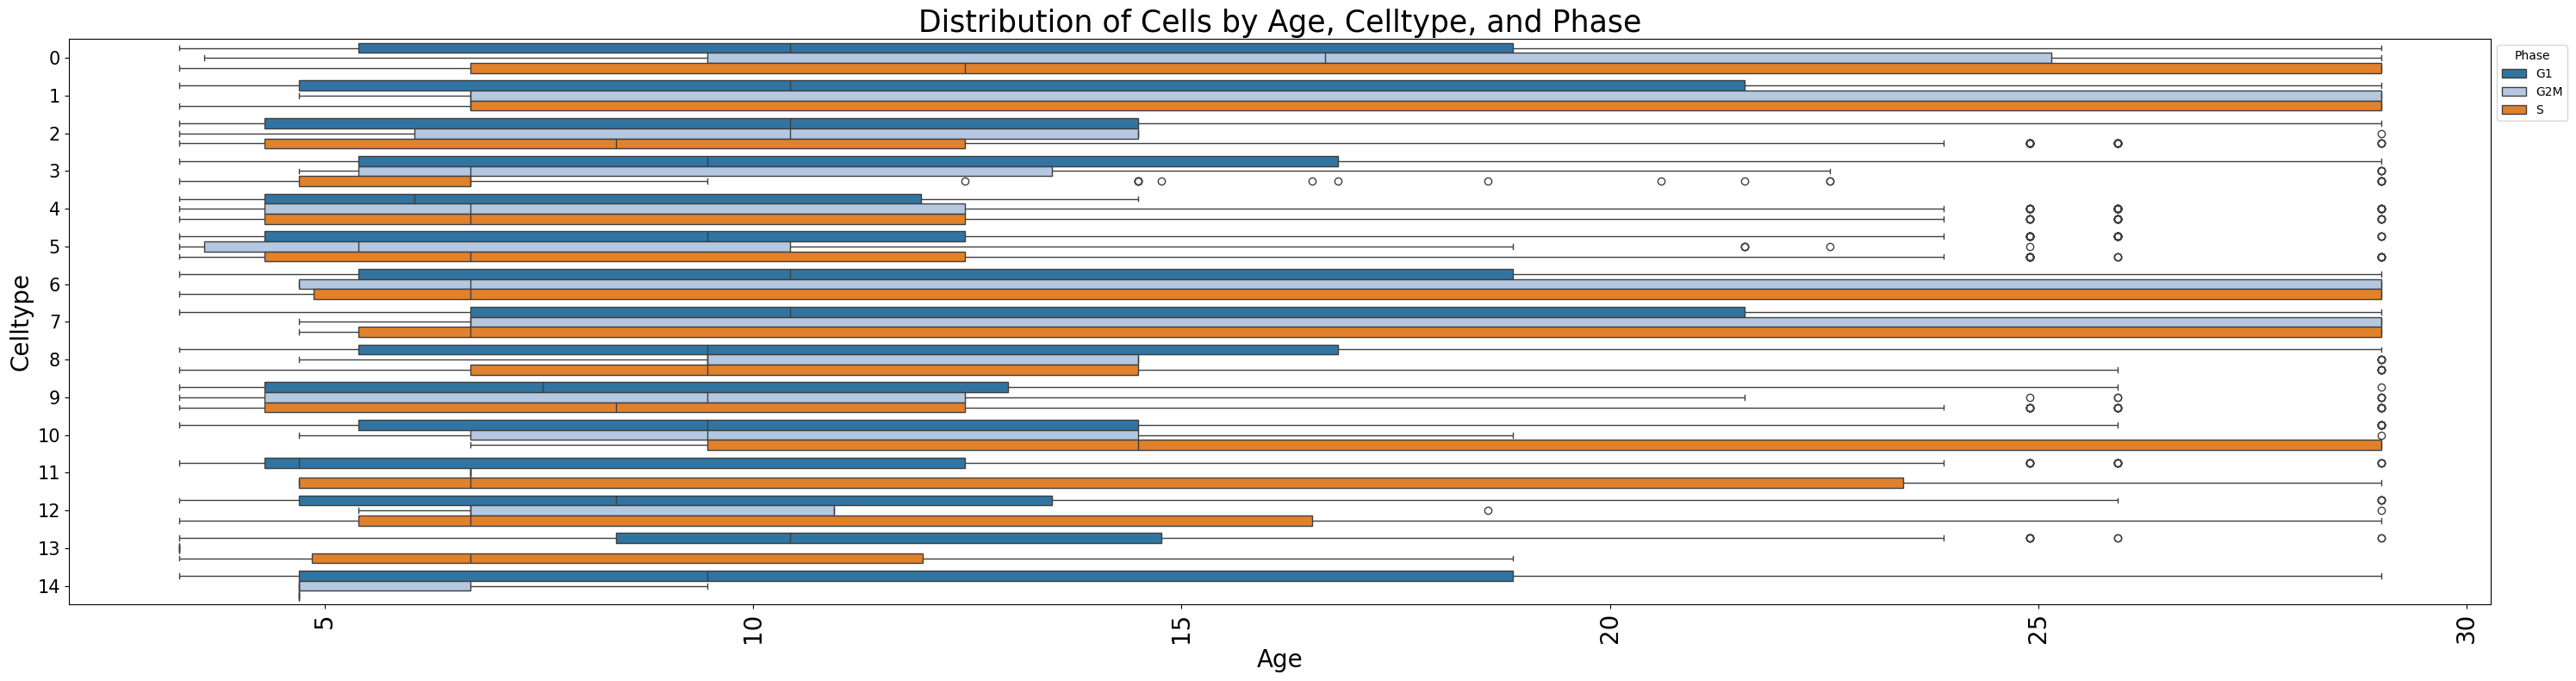

In [22]:
# Extract the relevant columns from the AnnData object
df = adata.obs[['Age', 'Celltype', 'Phase']]

# Set up the plot
plt.figure(figsize=(30, 8))
sns.boxplot(x='Age', y='Celltype', hue='Phase', data=df, palette='tab20')
plt.xlabel('Age', size=20)
plt.ylabel('Celltype', size=20)
plt.title('Distribution of Cells by Age, Celltype, and Phase', size=25)
plt.xticks(rotation=90, size=20)
plt.yticks(size=15)
plt.legend(title='Phase', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

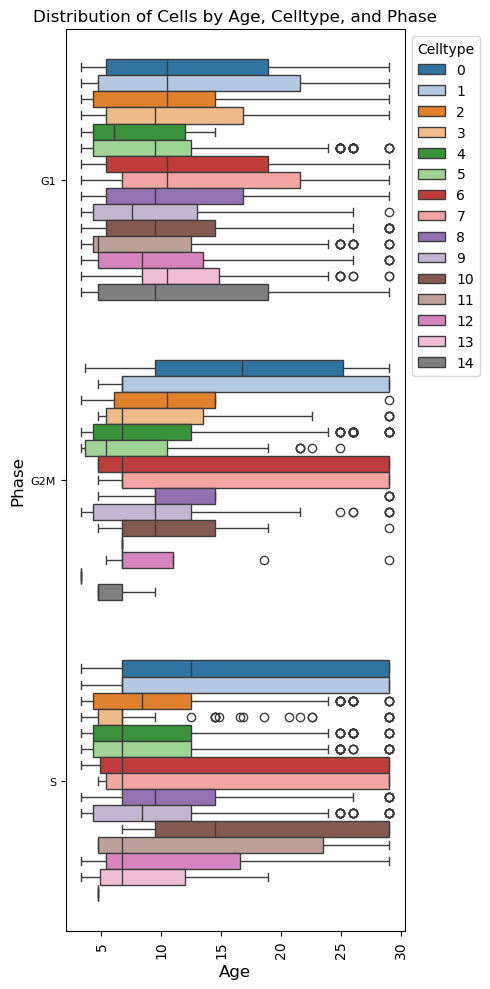

In [23]:
# Set up the plot
plt.figure(figsize=(5, 10))
sns.boxplot(x='Age', y='Phase', hue='Celltype', data=df, palette='tab20')
plt.xlabel('Age', size=12)
plt.ylabel('Phase', size=12)
plt.title('Distribution of Cells by Age, Celltype, and Phase', size=12)
plt.xticks(rotation=90, size=10)
plt.yticks(size=8)
plt.legend(title='Celltype', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

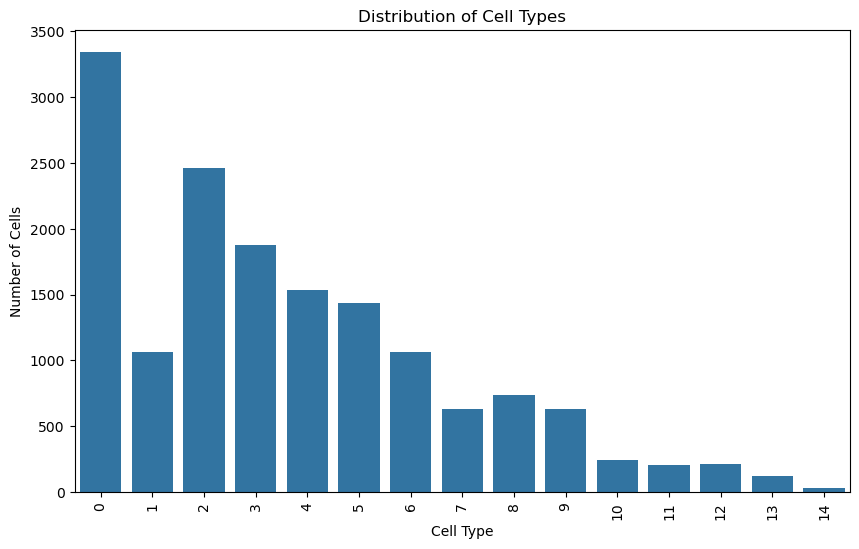

In [24]:
# Bar plot for cell type distribution
celltype_counts = adata.obs['Celltype'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=celltype_counts.index, y=celltype_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.title('Distribution of Cell Types')
plt.show()

In [25]:
adata.obs['Celltype'].value_counts()

Celltype
0     3343
2     2461
3     1877
4     1538
5     1432
6     1065
1     1060
8      736
7      631
9      627
10     245
12     212
11     203
13     121
14      31
Name: count, dtype: int64

In [26]:
# (Num Observations, Num Genes)
print(X.shape)
print(Y.shape)

(15582, 50)
(3000, 15582)


In [27]:
Y.mean()

8.206069096821118

### NMF Initialization

In [46]:
l=18
nmf_model = NMF(n_components=l, max_iter=100, init='random', random_state=0, alpha_H=2e-1, alpha_W=1e-7)

In [47]:
nmf_model.fit(Y.T)

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


NMF(alpha_H=0.2, alpha_W=1e-07, init='random', max_iter=100, n_components=18,
    random_state=0)

In [48]:
W = nmf_model.fit_transform(Y.T)

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


In [49]:
adata.var_names_make_unique()

In [50]:
factors = np.log(np.exp(W) + 1e-2)
loadings = nmf_model.components_.T#*5

In [51]:
acf_idx, acf_val = putil.dims_autocorr_timeseries(factors)

In [52]:
factors = factors[:, acf_idx]
loadings = loadings[:, acf_idx]

In [53]:
nmf_path = path.join(SPATH, 'nmf')
np.save(path.join(nmf_path, f'nmf_factors_iter=1000_rs=256_L={l}_rm(20.8, 22.6, 3.33)_new.npy'), factors)
np.save(path.join(nmf_path, f'nmf_loadings_iter=1000_rs=256_L={l}_rm(20.8, 22.6, 3.33)_new.npy'), loadings)

In [54]:
print(factors.shape)
print(loadings.shape)

(15582, 18)
(3000, 18)


In [36]:
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y.T, dtype=torch.float)

In [37]:
L = [10]
M = [3000]
K = [4]
lkzz_builds = [1]
sigmas = [0.3]
lengthscales = [0.02]
model_type = 'VNNGP'
batched=True
steps=2500

In [38]:
print(factors.shape)
print(loadings.shape)
print(X.shape)
print(Y.shape)

(15582, 12)
(3000, 12)
torch.Size([15582, 50])
torch.Size([15582, 3000])


/tmp/ipykernel_3220185/2433953900.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float).to(device)
/tmp/ipykernel_3220185/2433953900.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float).to(device)


  0%|          | 0/2500 [00:00<?, ?it/s]

/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/gp.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  little_Kzz = torch.tensor(little_Kzz, device=Kzz.device).float()


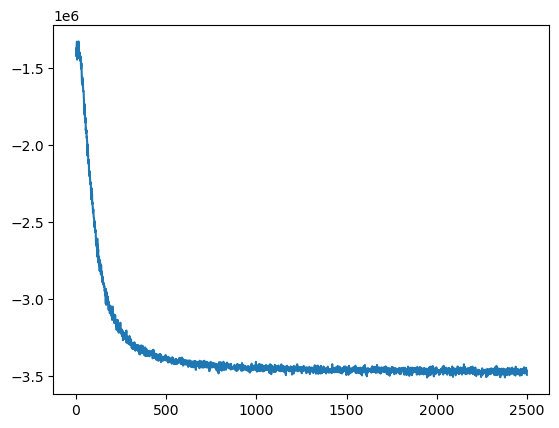

NameError: name 'ad' is not defined

In [39]:
for k in K:
    for s in sigmas:
        for l in lengthscales:
            dicts = {
                'L': 12, 
                'M': 3000, 
                'K': 8,
                'sigma': s, 
                'lengthscale': l, 
                'jtr': 1e-1,
                'batch_size': 128,
                'lr': 1e-2,
                'rs': 256,
                'lkzz_build': 1,
                'model': 'VNNGP',
                'L1_jitter': 1e-1,
            }
            
            
            kwargs = dicts
            file_path = model_type
            #X, Y = data_func()
            #K=None
            if model_type == 'VNNGP':
                file_path += f"_K={kwargs['K']}"
            
                if kwargs['lkzz_build']:
                    file_path += f"_lkzz={kwargs['lkzz_build']}"
                    
            file_path += f"_M={kwargs['M']}_L={kwargs['L']}_lr={kwargs['lr']}_jtr={kwargs['jtr']}_ls={kwargs['lengthscale']}_sigma={kwargs['sigma']}"
            if batched:
                file_path += f"_bs={kwargs['batch_size']}"

            #loadings_path = f"/engelhardt/home/pshrestha/vnngp/results/merfish/nmf/nmf_factors_iter=1000_rs=256_L={kwargs['L']}.npy"
            #factors_path = f"/engelhardt/home/pshrestha/vnngp/results/merfish/nmf/nmf_factors_iter=1000_rs=256_L={kwargs['L']}.npy"
            #factors = np.load(factors_path)
            #loadings = np.load(loadings_path)
            factors = np.array(factors)
            loadings = np.array(loadings)
                
            
            # with NMF initialization
            file_path += f"_NMFinit"
            X_array = np.array(X.cpu())
            Y_array = np.array(Y.cpu())
            model = putil.build_model(X_array, Y_array.T, loadings=loadings, factors=factors, model_type=model_type, kwargs=kwargs)
        
            putil.model_grads(model)
            model.prior.jitter=kwargs['jtr']
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
                
            model.to(device)
            #X = torch.tensor(X).type(torch.float)
            #Y = torch.tensor(Y).type(torch.float)
           # X_train = X.to(device)
            #Y_train = Y.to(device)
                
            start_time = time.time()
            X = torch.tensor(X, dtype=torch.float).to(device)
            Y = torch.tensor(Y, dtype=torch.float).to(device)
            losses, means, scales, idxs = putil.train_batched(model, optimizer, X.to(device), Y.T, device,
                                                        steps=steps, E=3, batch_size=kwargs['batch_size'], kwargs=kwargs)
            end_time = time.time()
                
            final_time = end_time - start_time
                
            #torch.save(model.state_dict(), f'{save_path}/{file_path}_state_dict.pth')
            #torch.save({'losses': losses,
                        #'means': means,
                        #'scales': scales,
                        #'time': final_time},
                        #f'{save_path}/{file_path}_model.pt')
            
            #print('sigmas:', model.prior.kernel.sigma)
            #print('lengthscale:', model.prior.kernel.lengthscale)
            
            fig, ax = plt.subplots()
            ax.plot(losses)
            #fig.suptitle(f"{model_type} Loss | sigma: {kwargs['sigma']}, lengthscale: {kwargs['lengthscale']}")
            plt.show()
            #fig.savefig(f'{save_path}/{file_path}_loss.png')
            #fig.close()
            
            #size=2
            #fig, axes = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
                
            model.cpu()
            qF, _, _ = model.prior(X.cpu(), kwargs=kwargs)
            mean = torch.exp(qF.mean).detach().numpy()
            #fig.suptitle(f'Factors | sigma: {kwargs["sigma"]}, lengthscale: {kwargs["lengthscale"]}')
            #fig.savefig(f'{save_path}/{file_path}_plot.png')
            #fig.close()

In [46]:
adata.obsm['X_nnnsf'] = mean.T
sc.pp.neighbors(adata, use_rep='X_nnnsf')
sc.tl.umap(adata)

for i in range((mean.T).shape[1]):
    adata.obs[f'Factor {i+1}'] = (mean.T)[:, i]

In [47]:
def plot_umap_factors(loadings, ad):
    L = loadings.shape[1]
    size = 2
    fig, axes = plt.subplots(L // 6, 6, figsize=(size * 6, size * (L // 6)), tight_layout=True)

    # Find the global vmin and vmax across all factors
    #vmin = loadings.min().min()
    #vmax = loadings.max().max()

    for i in range(L):
        curr_ax = axes[i // 6, i % 6]
        sc.pl.embedding(
            ad,
            basis='umap_har',
            color=f'Factor {i+1}',
            ax=curr_ax,
            show=False,
            cmap='magma', 
        )

    plt.tight_layout()
    plt.show()
    return fig, axes

def plot_umap_factors_by_age(loadings, adata, dot_size=10):  # Added dot_size parameter
    L = loadings.shape[1]
    size = 2
    unique_ages = sorted(adata.obs['Age'].unique())  # Sort ages from youngest to oldest
    print(unique_ages)
    num_ages = len(unique_ages)
    vmin = loadings.min().min()
    vmax = loadings.max().max()

    
    # Create subplots
    fig, axes = plt.subplots(L, num_ages + 1, figsize=(size * (num_ages + 1), size * L), tight_layout=True)
    
    for i in range(L):
        # Plot the original UMAP for the factor
        sc.pl.embedding(adata, basis='umap_har', color=f'Factor_{i+1}', ax=axes[i, 0], show=False, cmap='magma', size=dot_size, vmin=vmin, vmax=vmax)
        axes[i, 0].set_title(f'Factor {i+1} - Original')
        
        # Plot UMAPs for each age
        for j, age in enumerate(unique_ages):
            adata_age = adata[adata.obs['Age'] == age]
            sc.pl.embedding(
            adata_age,
            basis='umap_har',
            color=f'Factor {i+1}',
            ax=axes[i, j + 1],
            show=False,
            cmap='viridis',
            vmin=vmin,
            vmax=vmax,  # Set the global color limits
            size=dot_size
            )
            axes[i, j + 1].set_title(f'Age {age}')
    
    plt.tight_layout()
    plt.show()
    return fig

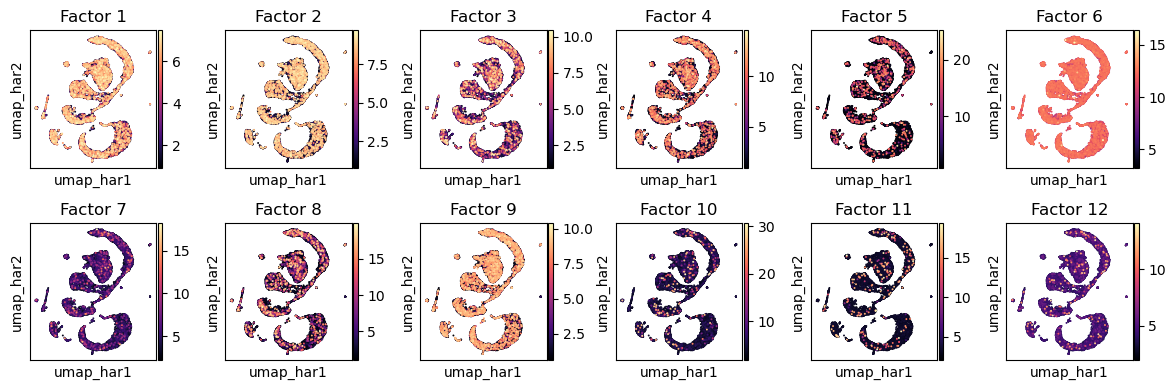

In [48]:
fig, ax = plot_umap_factors(loadings, adata)

In [51]:
W = (model.W).cpu()
W_transformed = nn.functional.softplus(W.T)
W_transformed = W_transformed.detach().numpy()
y_nnnsf = ((mean.T)).dot(W_transformed)

In [53]:
# Create a DataFrame for loadings and assign gene names as index
loadings_df = pd.DataFrame(W_transformed.T, index=adata.var_names)

# Get the top 10 genes for each factor
top_genes = {}

for factor in range(loadings_df.shape[1]):
    # Sort genes by loadings in descending order for this factor
    sorted_genes = loadings_df.iloc[:, factor].sort_values(ascending=False)
    
    # Get the top 10 genes
    top_genes[f'Factor_{factor+1}'] = sorted_genes.head(10).index.tolist()

# Convert the result into a DataFrame to visualize
top_genes_df = pd.DataFrame(top_genes)
print(top_genes_df)

        Factor_1 Factor_2 Factor_3       Factor_4       Factor_5 Factor_6  \
0            Lxn    Vcam1     Ehd2        Atp13a5          Otogl      Fos   
1          Bcas1  Gm13889   Angpt2         Galnt6         Phf11d   Clec3b   
2          Il1r1    Olfm5    Orai1         Phldb1         Mcemp1    Nr1h3   
3           Drd1     Rgs2   Plppr4        Gm17056          Slfn8    Stab1   
4         Rab33a      Ank     Cnmd        St8sia2        Khdrbs3    Meis2   
5        Gm47093   Pcdh18    Lyzl4  A330102I10Rik          Fbln7  Tmem119   
6         Cfap45     Ano4    Foxd1         Ifitm2           Pllp    Foxl2   
7        Gm16143  Neurod6    Ptgs1          Aurkb  E130114P18Rik  Nckap1l   
8  1110017D15Rik   Ms4a4b   Gpcpd1          Tgfbi          Pde3b   S100a1   
9           Fgd2     Glul     Hes1        Camk2n1          Cxadr  Slc15a3   

    Factor_7 Factor_8       Factor_9 Factor_10 Factor_11 Factor_12  
0      N4bp3  Racgap1        Atp13a5      Hes5    Gimap6     Clic1  
1    St8sia2  

In [55]:
top_genes_indices = {}

# Loop through each factor in top_genes_df
for factor in top_genes_df.columns:
    # Get the gene names for the factor
    genes = top_genes_df[factor]
    
    # Find the corresponding indices of these genes in ad.var_names
    indices = [list(adata.var_names).index(gene) for gene in genes]
    
    # Store the indices in the dictionary
    top_genes_indices[factor] = indices

# Convert the dictionary to a DataFrame for easier viewing
top_genes_indices_df = pd.DataFrame(top_genes_indices)
print(top_genes_indices_df)

   Factor_1  Factor_2  Factor_3  Factor_4  Factor_5  Factor_6  Factor_7  \
0       522       505      1952       398      2539        49      1587   
1      1100       362      2280      1701      1533      2589      1234   
2      2298      2916      1171      1815      2538      1729       822   
3      2477       251      2285      2149      1680       508      1257   
4      1745      1994      2411      1234       496        93      2870   
5      2762      1927      2282      1703      2626       175       251   
6      2309      2201       821       335       429      2101       459   
7      2586      2892       358       779      1142      1346      2756   
8      2440      2638      1656      2012       996       727       177   
9      1033       541       688      1390      1199       646      1430   

   Factor_8  Factor_9  Factor_10  Factor_11  Factor_12  
0       427       398        152        936        940  
1      1656       829        881       2150       2924  
2  

Plotting factor 0
Plotting factor 1
Plotting factor 2
Plotting factor 3
Plotting factor 4
Plotting factor 5
Plotting factor 6
Plotting factor 7
Plotting factor 8
Plotting factor 9
Plotting factor 10
Plotting factor 11


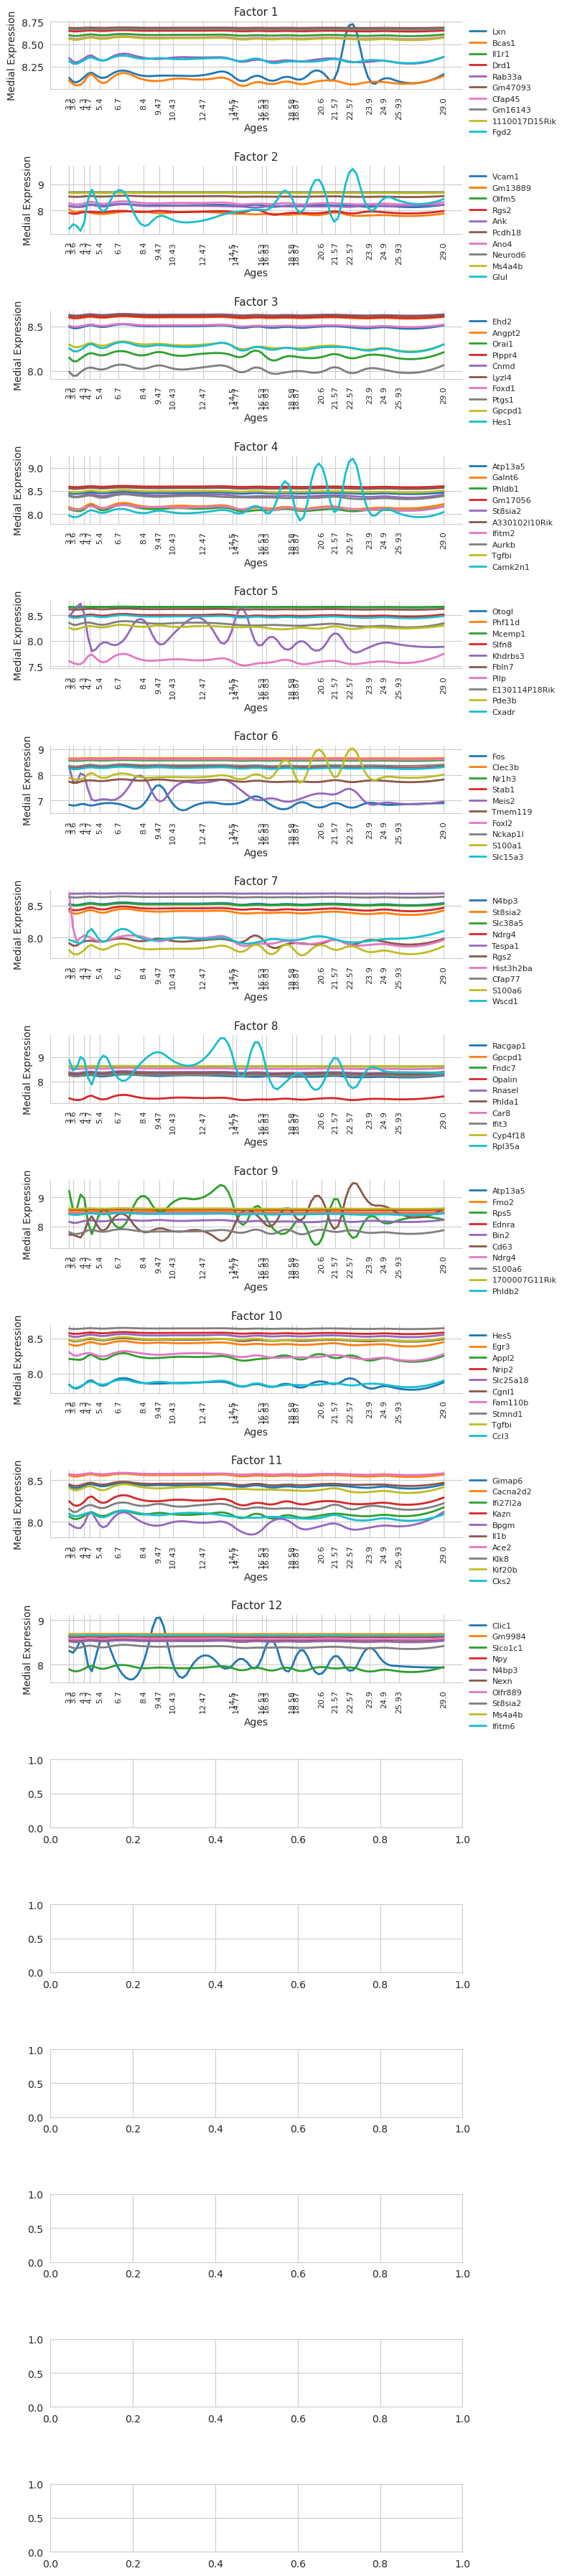

In [57]:
from scipy.interpolate import interp1d

L = (W_transformed.T).shape[1]  # Number of factors
size = 2
fig, axes = plt.subplots(18, 1, figsize=(size*4, size*18), tight_layout=False)

sns.set_style("whitegrid")

for i in range(L):
    print(f"Plotting factor {i}")
    top_genes = top_genes_indices_df[f'Factor_{i+1}']
    gene_names = adata.var_names[top_genes].to_list()
    gene_data = adata[:, top_genes].X

    df = pd.DataFrame(gene_data, columns=gene_names)
    df['Age'] = adata.obs['Age'].values
    
    df_aggregated = df.groupby('Age')[gene_names].median().reset_index()
    curr_ax = axes[i % 18]
    
    df_melted = pd.melt(df_aggregated, id_vars=['Age'], value_vars=gene_names, 
                        var_name='Gene', value_name='Expression')

    # Interpolate to create smoother lines
    for gene in gene_names:
        subset = df_melted[df_melted['Gene'] == gene]
        x = subset['Age']
        y = subset['Expression']
        f = interp1d(x, y, kind='quadratic')
        
        # Generate more points to make a smoother curve
        x_new = np.linspace(x.min(), x.max(), 100)
        y_smooth = f(x_new)
        
        curr_ax.plot(x_new, y_smooth, label=gene, linewidth=2)
        #curr_ax.scatter(x, y)
        curr_ax.set_xlabel("Ages")
        curr_ax.set_ylabel("Medial Expression")

    unique_ages = df_aggregated['Age'].unique()
    middle_age = unique_ages[len(unique_ages) // 2]
    tick_ages = [unique_ages[0], middle_age, unique_ages[-1]]
    
    curr_ax.set_xticks(unique_ages)
    #tick_labels = ['' for _ in unique_ages]
    #tick_labels[0] = unique_ages[0]
    #tick_labels[len(unique_ages) // 2] = middle_age
    #tick_labels[-1] = unique_ages[-1]
    
    curr_ax.set_xticklabels(unique_ages, rotation=90, fontsize=8)
    curr_ax.set_title(f"Factor {i+1}", size=11)
    sns.despine(ax=curr_ax)
    curr_ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=8)

plt.subplots_adjust(hspace=0.7)  # Adjust spacing between plots
#plt.savefig(f'{SPATH}/median_expression_nnnsf_rm.png')
plt.show()